<a href="https://colab.research.google.com/github/djliden/deep_learning_practice/blob/main/notebooks/(Un)freezing%20and%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background 
This notebook roughly corresponds to the material starting on page 207 of the book (the end of Chapter 5).

The general idea is that we start with a pretained model that is fine-tuned for a different task. For example, the `resnet34` model that we often use was trained on the `ImageNet` dataset, which contains millions of hand-labeled images with tens of thousands of categories. We have been applying *transfer learning* to adapt the `resnet` models to our own purposes. In this notebook, I will briefly cover the basic methods in the `fastai` library for conducting transfer learning.

# Preparing the Data

I will be demonstrating this using the `PASCAL` dataset from chapter 6 (just to avoid exactly recreating what was already done in chapter 5).

In [1]:
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import pandas as pd
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

df = pd.read_csv(path/'train.csv')

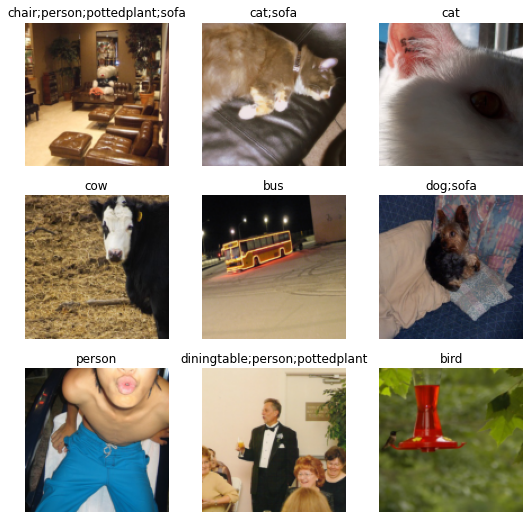

In [3]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)
dls.show_batch()

# Preparing the Model

In [4]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when 'inp' and 'targ' are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))
learn.metrics = partial(accuracy_multi, thresh=0.5)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Transfer Learning, step by step
Now we have a `cnn_learner` object that has *not* been trained for our present task. We want to use the `resnet` model to help us with our present task. But there's an obvious problem. The `ImageNet` dataset on which `resnet` was trained has more than 20,000 categories, while our dataset has only 20:

In [5]:
[x for x in dls.vocab]

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In general, the final linear layer of a neural network "uses a matrix with enough columns such that the output size is the same as the number of classes in our model." But we have a different number of classes, and the classes are different. So that final layer really doesn't help us. So we're going to discard it and replace it with a new final linear layer with the correct number of activations for our present problem.

But the newly-added linear layer doesn't do much for us yet. It has entirely random weights. Let's see what happens when we validate the model at this phase.

In [6]:
learn.validate()

(#2) [1.3876768350601196,0.5962747931480408]

Not great! We now need to train the weights of our new final layer to actually work for the present task. But we want to do this *without* doing any harm to the weights in the rest of the model, which were trained on tens of millions of images to be *pretty good* at image recognition in general.

In [7]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 64 x 64    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               64 x 64 x 32 x 32    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 32 x 32    128        True      
________________________________________________________________
ReLU                 64 x 64 x 32 x 32    0          False     
_________________________________________________

We can see that a lot of the layers are currently not trainable (they are "frozen"). Trainable layers are the `BatchNorm` layers (see [discussion](https://forums.fast.ai/t/why-are-batchnorm-layers-set-to-trainable-in-a-frozen-model/46560)) and the final linear layer. So when we next train the model, we will not be affecting the frozen layers. We're primarily training the final linear layer. We can do this "manually" with the `fit_one_cycle` method.

In [8]:
learn.fit_one_cycle(n_epoch=3, lr_max = 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.853506,0.501470,0.782191,00:30
1,0.503580,0.162949,0.953605,00:30
2,0.316314,0.144888,0.954163,00:30


And look at that! We're already above 95% accuracy without touching most of the parameters. The next step is to *unfreeze* our model and fine-tune the rest of the parameters.

In [9]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 64 x 64    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               64 x 64 x 32 x 32    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 32 x 32    128        True      
________________________________________________________________
ReLU                 64 x 64 x 32 x 32    0          False     
_________________________________________________

Now the previously-frozen layers of our model are trainable (unfrozen)! Let's pick a new learning rate and see if we can further improve the model by training the whole model for a few more epochs.

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=6.309573450380412e-07)

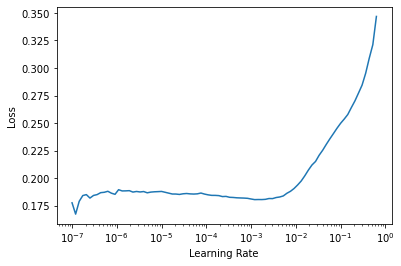

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(n_epoch=6, lr_max = 1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.183057,0.140464,0.956175,00:30
1,0.173314,0.130600,0.958466,00:30
2,0.161463,0.127060,0.959243,00:30
3,0.146378,0.122781,0.960378,00:30
4,0.137661,0.120106,0.961295,00:30
5,0.130849,0.119858,0.961136,00:30


# The Easy Way

The `fine_tune` method can do all of this work for us. First we'll reinitialize the model to reset the weights, and then we'll use the `fine_tune` method to train three epochs, unfreeze, and train another six epochs. This is just what we did above, so we expect similar results. Furthermore, the `fine_tune` method attempts to automatically apply discriminative learning rates.

In [12]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))
learn.metrics = partial(accuracy_multi, thresh=0.5)

learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.998295,0.725525,0.580657,00:30
1,0.865955,0.564199,0.727888,00:30
2,0.644290,0.232667,0.943127,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.283219,0.180208,0.952191,00:31
1,0.224688,0.135614,0.956135,00:31
2,0.178919,0.120822,0.958566,00:30
3,0.149345,0.114726,0.960319,00:30
4,0.127901,0.111136,0.961574,00:30
5,0.116908,0.110573,0.961773,00:30


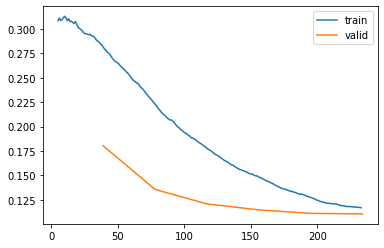

In [15]:
learn.recorder.plot_loss()

Marginally better than what we had before.

# Review
- When we initialize a model, most of its layers are *frozen*, meaning their parameters will not be adjusted if we `fit_one_cycle`.
- We can investigate frozen/unfrozen layers with `learn.summary`.
- When we train a newly-initialized model with frozen layers, we are training the final linear layer of the model for the present task.
- After we unfreeze the model, we can train for more epochs to "fine tune" the rest of the model. We typically won't be making large changes at this point as the model has already been trained.

In [18]:
test = pd.read_csv(path/'test.csv')
testds = dblock.datasets(test)

KeyError: ignored